In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
train_data = pd.read_csv('../input/sign-language-mnist/sign_mnist_train.csv')

In [3]:
test_data = pd.read_csv('../input/sign-language-mnist/sign_mnist_test.csv')

In [4]:
train_data.head(2)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149


In [5]:
train_data.memory_usage().sum()

172417528

In [6]:
for col in train_data.columns:
    train_data[col] = train_data[col].astype(np.int16)

In [7]:
train_data.memory_usage().sum()

43104478

In [8]:
x = train_data.iloc[:,1:].values
print("Number of images: ", x.shape[0])

Number of images:  27455


In [9]:
labels = train_data['label']
train_data.drop('label', axis = 1, inplace = True)

In [10]:
unique_val = np.array(labels)
np.unique(unique_val)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int16)

In [11]:
Training_image1 = train_data.values
Training_image1.shape

(27455, 784)

In [12]:
Training_images = train_data.values
Training_images = np.array([np.reshape(i, (28,28)) for i in Training_images])
images = np.array([i.flatten() for i in Training_images])
images = images/255
images.shape

(27455, 784)

In [13]:
from sklearn.preprocessing import LabelBinarizer
label_binrizer = LabelBinarizer()
labels = label_binrizer.fit_transform(labels)

In [14]:
batch_size = 64
num_classes = 24
epochs = 50
#epochs = 8

In [15]:
from keras.preprocessing.image import ImageDataGenerator

In [16]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    rescale=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

In [17]:
tt = datagen.flow(images[0].reshape(1,28,28,1))

In [18]:
imgs = [(next(tt)[0]) for _ in range(50)]

/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [19]:
imgs[0].shape

(28, 28, 1)

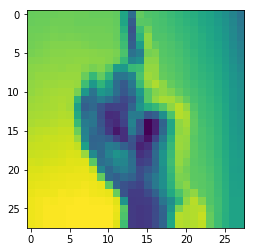

In [20]:
plt.imshow(imgs[0].reshape(28,28))

In [21]:
import gc

In [22]:
gc.collect()

0

In [23]:
new_images=[]
new_labels=[]
for i in range(len(images)):
    tt= datagen.flow(images[i].reshape(1,28,28,1))
    labl = [labels[i] for _ in range(20)]
    imgs = [next(tt)[0] for _ in range(20)]
    new_images.append(imgs)
    new_labels.append(labl)

In [24]:
new_im = np.array(new_images)

In [25]:
im_pa = np.reshape(new_im,(27455*20,784))

In [26]:
lb_pa = np.reshape(new_labels,(27455*20,24))

(<matplotlib.image.AxesImage at 0x7f06be781dd8>,
 array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]))

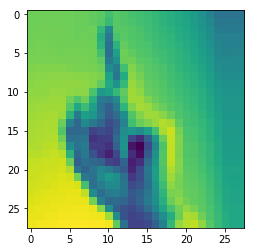

In [27]:
plt.imshow(im_pa[1].reshape(28,28)),lb_pa[1]

In [28]:
images.shape, im_pa.shape

((27455, 784), (549100, 784))

In [29]:
labels.shape,lb_pa.shape

((27455, 24), (549100, 24))

In [30]:
im_data = np.concatenate((images,im_pa))

In [31]:
label_data = np.concatenate((labels, lb_pa))

In [32]:
label_data.shape

(576555, 24)

In [46]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(im_data, label_data, test_size = 0.2, random_state = 42) ##could also use stratification maybe

In [34]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [35]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU

In [36]:
with tpu_strategy.scope():
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(3,3), activation = 'relu',padding='same', input_shape=(28, 28 ,1) ))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(256, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.20))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.20))
    model.add(Dense(num_classes, activation = 'softmax'))

    model.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])


In [38]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [40]:
es = EarlyStopping(monitor='val_loss', min_delta=0.008 , patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
mc = ModelCheckpoint('best_model_TPU.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [42]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=20, batch_size=batch_size, callbacks=[es, mc])

Train on 461244 samples, validate on 115311 samples
Epoch 1/20
461244/461244 [==============================] - 268s 580us/step - loss: 0.6141 - accuracy: 0.7944 - val_loss: 0.0780 - val_accuracy: 0.9758

Epoch 00001: val_accuracy improved from -inf to 0.97579, saving model to best_model_TPU.h5
Epoch 2/20
461244/461244 [==============================] - 261s 566us/step - loss: 0.1034 - accuracy: 0.9676 - val_loss: 0.0133 - val_accuracy: 0.9961

Epoch 00002: val_accuracy improved from 0.97579 to 0.99615, saving model to best_model_TPU.h5
Epoch 3/20
461244/461244 [==============================] - 263s 569us/step - loss: 0.0600 - accuracy: 0.9821 - val_loss: 0.0104 - val_accuracy: 0.9968

Epoch 00003: val_accuracy improved from 0.99615 to 0.99683, saving model to best_model_TPU.h5
Epoch 4/20
461244/461244 [==============================] - 261s 566us/step - loss: 0.0437 - accuracy: 0.9876 - val_loss: 0.0184 - val_accuracy: 0.9942

Epoch 00004: val_accuracy did not improve from 0.99683
Ep

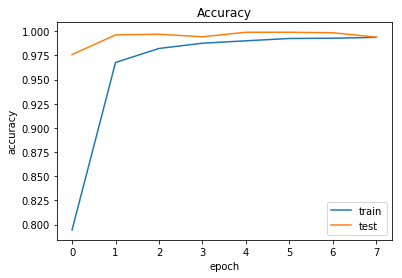

In [43]:
#history.history.keys()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

In [44]:
model.save('Aug_TPU_Sign_ES_P3.h5')